In [1]:
import json
import tabulate
import evaluation

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Origin", "Faulty engine", "Size", "Function Count"]

for test_name, data in metrics.items():
    metadata = data['metadata']
    table_data.append([
        test_name,
        metadata['origin'],
        metadata['engine'],
        data['rq2']['original-size-code'],
        metadata['function_count']
    ])
# Sort the table data by the original size code
table_data.sort(key=lambda row: row[3] if isinstance(row[3], (int, float)) else float('inf'))

# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, intfmt=",", tablefmt="latex_raw")

# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")

# Save the table to a file
rq1_table_path = f'{evaluation.PAPER_PATH}/table/eval_set.tex'
with open(rq1_table_path, 'w') as file:
    print(latex_table)
    file.write(latex_table)
    print(f"Table saved to {rq1_table_path}")

\begin{tabular}{lllrr}
\hline
 Name          & Origin        & Faulty engine    &      Size &   Function Count \\
\hline
 wasmedge\#3018 & WASMaker      & wasmedge-96ecb67 &     1,913 &               12 \\
 wamr\#2789     & WASMaker      & wamr-0b0af1b     &    17,604 &               58 \\
 wasmedge\#3019 & WASMaker      & wasmedge-96ecb67 &    19,098 &               76 \\
 wamr\#2862     & WASMaker      & wamr-7308b1e     &    19,727 &               73 \\
 wamr\#2450     & WASMaker      & wamr-0b0af1b     &    24,482 &               66 \\
 wasmedge\#3076 & WASMaker      & wasmedge-96ecb67 &    31,365 &              131 \\
 mandelbrot    & Wasm-R3-Bench & wizard-0d6926f   &    64,515 &              167 \\
 wasmedge\#3057 & WASMaker      & wasmedge-96ecb67 &   243,564 &            1,006 \\
 guiicons      & Wasm-R3-Bench & wizard-0d6926f   &   285,840 &              505 \\
 rtexviewer    & Wasm-R3-Bench & wizard-0d6926f   &   296,617 &              688 \\
 rfxgen        & Wasm-R3-Bench &

In [2]:
import json
from statistics import stdev
from numpy import average
import tabulate
import evaluation

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Sort the metrics by key
metrics = dict(sorted(metrics.items()))

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Target", "Smaller", "Bigger", "Failed",  "Size Reduced", "Split Time(s)", "RR Time(s)"]


for test_name, data in metrics.items():
    metadata = data['metadata']
    print(f"Bigger cases for {test_name}: {[k for k, obj in data['rq1'].items() if obj['is-executed'] if obj['sliced_file_size'] != 'fail' and obj['sliced_code_size'] >= metadata['code_size']]}")
    executed_objs = [obj for obj in data['rq1'].values() if obj['is-executed']]
    target_function_count = len(executed_objs)
    split_time = average([obj['split-time'] / 1000 for obj in executed_objs]) if executed_objs else 'N/A'
    rr_time_values = [obj['rr-time'] / 1000 for obj in executed_objs if obj['rr-time'] != 'fail']
    rr_time = average(rr_time_values) if rr_time_values else 'N/A'
    try:
        rr_reduced = sum(1 for obj in executed_objs if obj['sliced_file_size'] != 'fail' and obj['sliced_code_size'] < metadata['code_size'])
        rr_bigger = sum(1 for obj in executed_objs if obj['sliced_file_size'] != 'fail' and obj['sliced_code_size'] >= metadata['code_size'])
        rr_fail = sum(1 for obj in executed_objs if obj['sliced_file_size'] == 'fail')
    except:
        raise Exception(f"Error in {test_name}")
    rr_reduction_rate_values = [obj['sliced_code_size'] / metadata['code_size'] * 100 for obj in executed_objs if obj['sliced_file_size'] != 'fail' and obj['sliced_code_size'] < metadata['code_size']]
    rr_reduction_rate = f"{average(rr_reduction_rate_values):.2f}%" if rr_reduction_rate_values else 'N/A'
    table_data.append([
        test_name,
        target_function_count,
        rr_reduced,
        rr_bigger,
        rr_fail,
        rr_reduction_rate,
        split_time,
        rr_time,
    ])

# Sort the table data by the original size code
table_data.sort(key=lambda row: metrics[row[0]]['rq2']['original-size-code'])

# Calculate the sum of all the rows
sum_target_function_count = sum(row[1] for row in table_data)
sum_rr_failed = sum(row[4] for row in table_data)
sum_rr_bigger = sum(row[3] for row in table_data)
sum_rr_reduced = sum(row[2] for row in table_data)

total_split_time_values = [obj['split-time'] / 1000 for data in metrics.values() for obj in data['rq1'].values() if obj['rr-time'] != 'fail' and obj['is-executed']]
average_split_time = average(total_split_time_values)
stdev_split_time = stdev(total_split_time_values)
total_rr_time_values = [obj['rr-time'] / 1000 for data in metrics.values() for k,obj in data['rq1'].items() if obj['rr-time'] != 'fail' and obj['is-executed']]
average_rr_time = average(total_rr_time_values) if total_rr_time_values else 'N/A'
stdev_rr_time = stdev(total_rr_time_values) if total_rr_time_values else 'N/A'
total_rr_reduction_rate_values = [obj['sliced_code_size'] / data['metadata']['code_size'] * 100 for data in metrics.values() for obj in data['rq1'].values() if obj['sliced_file_size'] != 'fail' and obj['is-executed'] if obj['sliced_code_size'] < data['metadata']['code_size']]
average_rr_reduction_rate = f"{average(total_rr_reduction_rate_values):.2f}%" if total_rr_reduction_rate_values else 'N/A'

# Append the total row to the table data
table_data.append([
    "Sum",
    sum_target_function_count,
    sum_rr_reduced,
    sum_rr_bigger,
    sum_rr_failed,
])

table_data.append([
    'Average',
    '',
    '',
    '',
    '',
    average_rr_reduction_rate,
    average_split_time,
    average_rr_time,
])

for row in table_data:
    for i, cell in enumerate(row):
        if isinstance(cell, float):
            row[i] = f"{cell:.2f}"

# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw", intfmt=",", floatfmt=",.2f")

# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")
latex_table = latex_table.replace("%", "\\%")

# Add distinction for the total row
latex_table = latex_table.replace("Sum", "\\hline\nSum")

# Save the table to a file
rq2_table_path = f'{evaluation.PAPER_PATH}/table/rq2.tex'
with open(rq2_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq2_table_path}")

print(f'len(total_rr_reduction_rate_values): {len(total_rr_reduction_rate_values)}')
print(f'len(total_split_time_values): {len(total_split_time_values)}')
print(f'len(total_rr_time_values): {len(total_rr_time_values)}')
print(f'average_split_time: {average_split_time}')
print(f'stdev_split_time: {stdev_split_time}')
print(f'average_rr_time: {average_rr_time}')
print(f'stdev_rr_time: {stdev_rr_time}')
cases = []
fail_cases = []
for test_name, data in metrics.items():
    for fidx, obj in data['rq1'].items():
        if obj['is-executed']:
            if obj['sliced_file_size'] != 'fail':
                if obj['sliced_code_size'] > data['metadata']['code_size']:
                    cases.append(f"{test_name}-{fidx}")
            else:
                fail_cases.append(f"{test_name}-{fidx}")

# Sort the cases
cases.sort()
fail_cases.sort()

# Print the sorted cases
print(f"Total number of cases where sliced_file_size is greater than metadata size: {len(cases)}")
print(f"Total number of cases where sliced_file_size is 'fail': {len(fail_cases)}")

ValueError: too many values to unpack (expected 2)

[1913, 17604, 24482, 19727, 19098, 31365, 64515, 285840, 416692, 410845, 398627, 378918, 296617, 243564, 607293, 719538, 628046, 3914616, 5198069, 4342199]
X-axis tick locations: [-1000000.        0.  1000000.  2000000.  3000000.  4000000.  5000000.
  6000000.]
Figure saved to /home/don/rr-reduce-paper/issta_2025/figures/rq2-graph.pdf


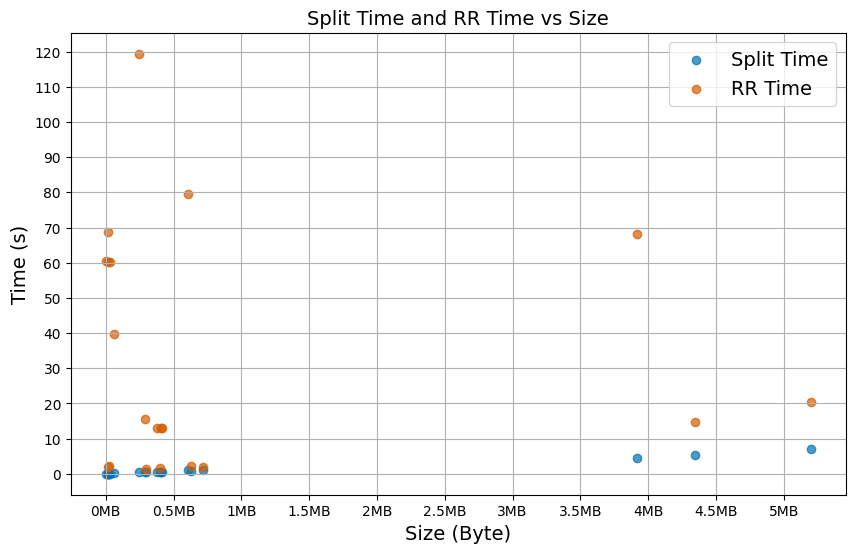

In [18]:
import json
import evaluation
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Function to calculate average, ignoring 'fail' values
def average(lst):
    valid = [x for x in lst if x != 'fail']
    return sum(valid) / len(valid) if valid else 0

x_data = [data['metadata']['code_size'] for data in metrics.values()]
split_time_data = [average([obj['split-time'] / 1000 for obj in data['rq1'].values() if obj['is-executed'] and obj['sliced_file_size'] != "fail" and  obj['sliced_code_size'] < data['metadata']['code_size']]) for data in metrics.values()]
rr_time_data = [average([obj['rr-time'] / 1000 for obj in data['rq1'].values() if obj['is-executed'] and obj['sliced_file_size'] != "fail" and  obj['sliced_code_size'] < data['metadata']['code_size']]) for data in metrics.values()]


# Convert to numpy arrays
x = np.array(x_data)
y_split = np.array(split_time_data)
y_rr = np.array(rr_time_data)

# Calculate linear regression statistics
slope_split, intercept_split, r_value_split, p_value_split, std_err_split = stats.linregress(x, y_split)
slope_rr, intercept_rr, r_value_rr, p_value_rr, std_err_rr = stats.linregress(x, y_rr)

color_split = '#0072B2'  # Blue
color_rr = '#D55E00'  # Vermilion

plt.figure(figsize=(10, 6))
plt.scatter(x_data, split_time_data, alpha=0.7, label='Split Time', color=color_split)
plt.scatter(x_data, rr_time_data, alpha=0.7, label='RR Time', color=color_rr)

# Increase font sizes for labels and title
plt.xlabel('Size (Byte)', fontsize=14)
plt.ylabel('Time (s)', fontsize=14)
plt.title('Split Time and RR Time vs Size', fontsize=14)
plt.legend(fontsize=14)

print(x_data)
# Get current tick locations and labels
locs, labels = plt.xticks()
print("X-axis tick locations:", locs)
xticks = [0,  500000, 1000000, 1500000, 2000000, 2500000,  3000000, 3500000,  4000000, 4500000,  5000000]
plt.xticks(ticks=xticks, labels=['0M', '0.5M', '1M', '1.5M', '2M', '2.5M', '3M', '3.5M', '4M', '4.5M', '5M'])
plt.yticks(np.arange(0, 130, 10))  # Y-axis ticks every 10 units
plt.grid(True)

# Save the figures to a file
fig_path_pdf = f'{evaluation.PAPER_PATH}/figures/rq2-graph.pdf'
plt.savefig(fig_path_pdf)
print(f"Figure saved to {fig_path_pdf}")

In [11]:
import json
from numpy import average
import tabulate
import evaluation

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Input Size", "RR-Reduce Size",  "RR-Reduce Time(s)", "wasm-reduce Size", "wasm-reduce Time(s)", "wasm-shrink Size", "wasm-shrink Time(s)"]

for test_name, data in metrics.items():
    metadata = data['metadata']
    original_size = data['rq2'].get('original-size-code')
    rr_reduce_size = data['rq2'].get('wasm-slice-size-code')
    rr_reduce_time = data['rq2'].get('wasm-slice-time')
    wasm_reduce_size = data['rq2'].get('wasm-reduce-size-code')
    wasm_reduce_time = data['rq2'].get('wasm-reduce-time')
    wasm_shrink_size = data['rq2'].get('wasm-shrink-size-code')
    wasm_shrink_time = data['rq2'].get('wasm-shrink-time')
    table_data.append([
        test_name,
        original_size,
        rr_reduce_size,
        rr_reduce_time,
        wasm_reduce_size,
        wasm_reduce_time,
        wasm_shrink_size,
        wasm_shrink_time,
    ])

    # Sort the table data by the original size
table_data.sort(key=lambda row: row[1] if isinstance(row[1], (int, float)) else float('inf'))

# Collect where rr-reduce size is bigger than wasm-reduce size and vice versa
rr_bigger = []
wasm_bigger = []


# Calculate the average values
average_original_size = average([row[1] for row in table_data])
average_rr_reduce_size = average([row[2] for row in table_data])
average_rr_reduce_time = average([row[3] for row in table_data])
average_wasm_reduce_size = average([row[4] for row in table_data])
average_wasm_reduce_time = average([row[5] for row in table_data])
average_wasm_shrink_size = average([row[6] for row in table_data])
average_wasm_shrink_time = average([row[7] for row in table_data])
table_data.append([
    "Average",
    average_original_size,
    average_rr_reduce_size,
    average_rr_reduce_time,
    average_wasm_reduce_size,
    average_wasm_reduce_time,
    average_wasm_shrink_size,
    average_wasm_shrink_time,
])


# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw", intfmt=",", floatfmt=",.0f")

# Replace the single row header with a custom double row header
old_header = r"""\begin{tabular}{lrrrrrrr}
\hline
 Name          &   Input Size &   RR-Reduce Size &   RR-Reduce Time(s) &   wasm-reduce Size &   wasm-reduce Time(s) &   wasm-shrink Size &   wasm-shrink Time(s) \\"""
new_header = r"""\begin{tabular}{lr|rr|rr|rr}
    \hline
    \multicolumn{2}{c|}{} & \multicolumn{2}{c|}{RR-Reduce} & \multicolumn{2}{c|}{wasm-reduce} & \multicolumn{2}{c}{wasm-shrink} \\
    Name & Input Size & Size & Time(s) & Size & Time(s) & Size & Time(s) \\"""

latex_table = latex_table.replace(old_header, new_header)


# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")
latex_table = latex_table.replace("%", "\\%")
# Add distinction for the total row
latex_table = latex_table.replace("Average", "\\hline\n\\textbf{Average}")

# Save the table to a file
rq4_table_path = f'{evaluation.PAPER_PATH}/table/rq1.tex'
with open(rq4_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq4_table_path}")


\begin{tabular}{lr|rr|rr|rr}
    \hline
    \multicolumn{2}{c|}{} & \multicolumn{2}{c|}{RR-Reduce} & \multicolumn{2}{c|}{wasm-reduce} & \multicolumn{2}{c}{wasm-shrink} \\
    Name & Input Size & Size & Time(s) & Size & Time(s) & Size & Time(s) \\
\hline
 wasmedge\#3018 &        1,913 &              454 &                 120 &                 24 &                    38 &                162 &                   106 \\
 wamr\#2789     &       17,604 &              336 &                 245 &                  9 &                   204 &                  9 &                   104 \\
 wasmedge\#3019 &       19,098 &              716 &                 121 &                 12 &                   375 &              1,473 &                   190 \\
 wamr\#2862     &       19,727 &            1,829 &                 182 &                 36 &                    83 &                582 &                   228 \\
 wamr\#2450     &       24,482 &            1,061 &                  14 &             

In [32]:
# Compute average size where original size is less than 100k
table_data_less_than_100k = [row for row in table_data if row[1] < 100000]
average_original_size_less_than_100k = average([row[1] for row in table_data_less_than_100k])
average_rr_reduce_size_less_than_100k = average([row[2] for row in table_data_less_than_100k])
average_wasm_reduce_size_less_than_100k = average([row[4] for row in table_data_less_than_100k])
average_rr_reduce_time_less_than_100k = average([row[3] for row in table_data_less_than_100k])
average_wasm_reduce_time_less_than_100k = average([row[5] for row in table_data_less_than_100k])
print(f"Average Original Size for <100k: {average_original_size_less_than_100k}")
print(f"Average RR-Reduce Size for <100k: {average_rr_reduce_size_less_than_100k}")
print(f"Average wasm-reduce Size for <100k: {average_wasm_reduce_size_less_than_100k}")
print(f"Average RR-Reduce Time for <100k: {average_rr_reduce_time_less_than_100k}")
print(f"Average wasm-reduce Time for <100k: {average_wasm_reduce_time_less_than_100k}")
print('')

# Compute average size where original size is 100k~1mil
table_data_100k_1mil = [row for row in table_data if 100000 <= row[1] <= 1000000]
average_original_size_100k_1mil = average([row[1] for row in table_data_100k_1mil])
average_rr_reduce_size_100k_1mil = average([row[2] for row in table_data_100k_1mil])
average_wasm_reduce_size_100k_1mil = average([row[4] for row in table_data_100k_1mil])
average_rr_reduce_time_100k_1mil = average([row[3] for row in table_data_100k_1mil])
average_wasm_reduce_time_100k_1mil = average([row[5] for row in table_data_100k_1mil])
print(f"Average Original Size for 100k~1mil: {average_original_size_100k_1mil}")
print(f"Average RR-Reduce Size for 100k~1mil: {average_rr_reduce_size_100k_1mil}")
print(f"Average wasm-reduce Size for 100k~1mil: {average_wasm_reduce_size_100k_1mil}")
print(f"Average RR-Reduce Time for 100k~1mil: {average_rr_reduce_time_100k_1mil}")
print(f"Average wasm-reduce Time for 100k~1mil: {average_wasm_reduce_time_100k_1mil}")
print('')

# Compute average size where original size is more than 1 mil
table_data_more_than_1mil = [row for row in table_data if row[1] > 1000000]
average_original_size_more_than_1mil = average([row[1] for row in table_data_more_than_1mil])
average_rr_reduce_size_more_than_1mil = average([row[2] for row in table_data_more_than_1mil])
average_wasm_reduce_size_more_than_1mil = average([row[4] for row in table_data_more_than_1mil])
average_rr_reduce_time_more_than_1mil = average([row[3] for row in table_data_more_than_1mil])
average_wasm_reduce_time_more_than_1mil = average([row[5] for row in table_data_more_than_1mil])
print(f"Average Original Size for >1mil: {average_original_size_more_than_1mil}")
print(f"Average RR-Reduce Size for >1mil: {average_rr_reduce_size_more_than_1mil}")
print(f"Average wasm-reduce Size for >1mil: {average_wasm_reduce_size_more_than_1mil}")
print(f"Average RR-Reduce Time for >1mil: {average_rr_reduce_time_more_than_1mil}")
print(f"Average wasm-reduce Time for >1mil: {average_wasm_reduce_time_more_than_1mil}")
print('')

Average Original Size for <100k: 25529.14285714286
Average RR-Reduce Size for <100k: 13836.857142857143
Average wasm-reduce Size for <100k: 3789.714285714286
Average RR-Reduce Time for <100k: 631.2424745219095
Average wasm-reduce Time for <100k: 706.261567899159

Average Original Size for 100k~1mil: 480632.58181818185
Average RR-Reduce Size for 100k~1mil: 129388.08636363636
Average wasm-reduce Size for 100k~1mil: 122029.5818181818
Average RR-Reduce Time for 100k~1mil: 458.71716817292304
Average wasm-reduce Time for 100k~1mil: 2666.372729617899

Average Original Size for >1mil: 4484961.333333333
Average RR-Reduce Size for >1mil: 162413.66666666666
Average wasm-reduce Size for >1mil: 3375245.3333333335
Average RR-Reduce Time for >1mil: 1256.7587320804596
Average wasm-reduce Time for >1mil: 3600.0046389102936



In [2]:
import os, json

from heuristics_finder import get_heuristic_fidx


with open("metrics.json", "r") as f:
    metrics = json.load(f)

for test_name, data in metrics.items():
    dirname = os.path.dirname(data['metadata']['path'])
    oracle_path = os.path.join(dirname, 'oracle.py')
    input_path = os.path.join(dirname, f'{test_name}.wasm')
    heuristic_fidx = get_heuristic_fidx(input_path, oracle_path)
    print(f"{test_name}: {heuristic_fidx}")

# with open("metrics.json", "w") as f:
# json.dump(metrics, f, indent=4)


wasmedge#3018: []
wamr#2789: []
wamr#2450: []
wamr#2862: []
wasmedge#3019: []
wasmedge#3076: []
mandelbrot: []
guiicons: []
rguilayout: []
rguistyler: []
riconpacker: []
rfxgen: []
rtexviewer: []
wasmedge#3057: []
funky-kart: []
hydro: []
sqlgui: []
commanderkeen: []
boa: []
jsc: []
